<a href="https://www.kaggle.com/code/muichimon/mnist-cnn-ipynb?scriptVersionId=261289311" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.44MB/s]


In [3]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [4]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # the image input size is 28×28 — but in nn.Conv2d, we specify channels, not the spatial (height × width) directly.
        
        # First convolutional layer
        # Input channels = 1 (grayscale), output channels = 6, kernel size = 3, stride = 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)

        # Output shape after conv1	[26×26]×6
        
        # Second convolutional layer
        # Input channels = 6 (from previous layer), output channels = 16, kernel size = 3, stride = 1
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

        # Fully connected layers
        # Image size reduces after convolutions and pooling:
        # From 28x28 → 26x26 after conv1 → 13x13 after pool → 11x11 after conv2 → 5x5 after pool
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # F.max_pool2d(X, 2, 2) does 2×2 max pooling with stride 2.
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16) # Each output from the last pooling layer is size 16 × 5 × 5 = 400. -1 tells PyTorch to infer the batch size automatically.
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [5]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
params = [p.numel() for p in model.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>6}')
print(f'______\n{sum(params):>6}')

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04255064  accuracy:  78.483%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.07135552  accuracy:  85.825%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.34511933  accuracy:  88.706%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.02288632  accuracy:  90.479%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00748382  accuracy:  91.607%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00131749  accuracy:  92.442%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.56951123  accuracy:  93.093%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02044285  accuracy:  93.562%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00931381  accuracy:  93.985%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.07695929  accuracy:  94.290%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.05754223  accuracy:  97.667%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.07752873  accuracy:  97.767%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00297317  accuracy:  97.761%
epoch:  1  b

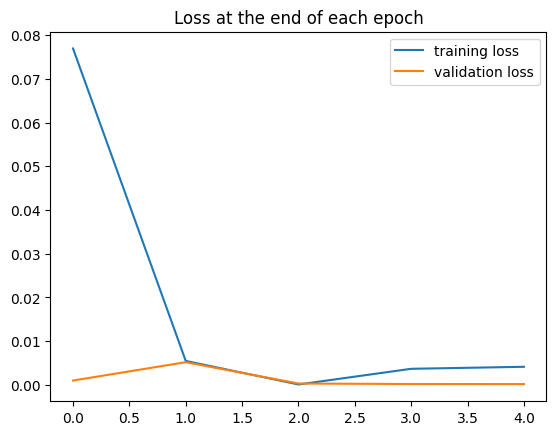

In [9]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

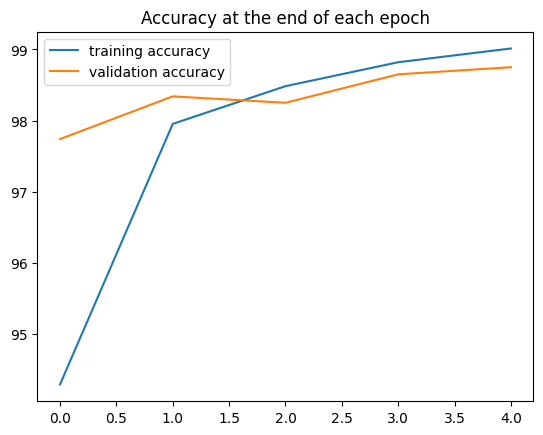

In [10]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();